<!--NOTEBOOK_HEADER-->
*This notebook contains material from the [ND-Pyomo-Cookbook](https://jckantor.github.io/ND-Pyomo-Cookbook) by
Jeffrey Kantor (jeff at nd.edu); the content is available [on Github](https://github.com/jckantor/ND-Pyomo-Cookbook.git).
*The text is released under the [CC-BY-NC-ND-4.0 license](https://creativecommons.org/licenses/by-nc-nd/4.0/legalcode),
and code is released under the [MIT license](https://opensource.org/licenses/MIT).*

<!--NAVIGATION-->
< [MAD Portfolio Optimization](http://nbviewer.jupyter.org/github/jckantor/ND-Pyomo-Cookbook/blob/master/notebooks/08.04-MAD-Portfolio-Optimization.ipynb) | [Contents](toc.ipynb) | [Index](index.ipynb) | [Style Guide](http://nbviewer.jupyter.org/github/jckantor/ND-Pyomo-Cookbook/blob/master/notebooks/A.00-Style-Guide.ipynb) ><p><a href="https://colab.research.google.com/github/jckantor/ND-Pyomo-Cookbook/blob/master/notebooks/08.05-Real-Options.ipynb"><img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open in Google Colaboratory"></a>

# Real Options

Keywords: glpk usage, real options, replicating portfolio

## Imports

In [1]:
%matplotlib inline

import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import scipy.stats as stats

import shutil
import sys
import os.path

if not shutil.which("pyomo"):
    !pip install -q pyomo
    assert(shutil.which("pyomo"))

if not (shutil.which("glpsol") or os.path.isfile("glpsol")):
    if "google.colab" in sys.modules:
        !apt-get install -y -qq glpk-utils
    else:
        try:
            !conda install -c conda-forge glpk 
        except:
            pass

assert(shutil.which("glpsol") or os.path.isfile("glpsol"))

from pyomo.environ import *

## Implementing a replicating portfolio in Pyomo

A replicating portfolio is the key concept for using of a binomial model to price options. In a nutshell, the value of an option is the money needed to construct a portfolio that replicates the option's payoff for every possible outcome. The replicating portfolio can be extended to applications involving 'real assets', including processes that convert commodity resources into higher value products.  

The period of the contract is broken into $N$ stages where $k=0$ denotes the start of the first stage of the option contract and $k=N$ denotes the end of the last stage. 

![TimeLineRealOption.png](https://github.com/jckantor/ND-Pyomo-Cookbook/blob/master/notebooks/figures/TimelineRealOption.png?raw=1)

The value of the replicating portfolio at the start of stage $k+1$ in state $s$ is given by 

$$W_{k,s} = x_{k,s}S^f_{k,s} + y_{k,s}$$

The portfolio consists of $x_{k,s}$ units of an underlying asset and $y_{k,s}$ is in units of cash. The values of $x_{k,s}$ or $y_{k,s}$ can be positive or negative. $S^f_{k,s}$ is the price of the underlying asset which is subject to statistical variability. Cash is assumed to have an investment return $r$ per period.

For each stage $k = 1, 2, \ldots, N$ and states $s = 0, 1, \ldots, k$, the value of the portfolio must 

1. prepay expenses $P_{k,s}$ required to maintain the asset through period $k$,
2. pay out income $Q_{k,s}$ and $Q_{k,s+1}$ the asset generated in stage $k$,
3. finance the portfolio for the subsequent states,
4. be the greater than the value any option available at node ($k$,$s$).

The last proposition establishes the value of holding the option. For the binomial model, these requirements produce two constraints associated with each stage and state. For stage $k$

![BinomialRealOption.png](https://github.com/jckantor/ND-Pyomo-Cookbook/blob/master/notebooks/figures/BinomialRealOption.png?raw=1)

we write

\begin{align*}
x_{k-1,s}S^f_{k,s} + (y_{k-1,s}-P_{k,s})(1+r) & \geq W_{k,s}  + Q_{k,s}\\
x_{k-1,s}S^f_{k,s+1} + (y_{k-1,s}-P_{k,s})(1+r) & \geq W_{k,s+1} + Q_{k,s+1}
\end{align*}

where we assume expenses are incurred immediately prior to the start of stage $k$, and income is accumulated immediately following completion of stage $k$.

## Example 1. Value of a fixed cash flow

Suppose we are considering the purchase of lease on property that could generate $10,000 per year of income for the next 10 years. We assume there is virtually no risk that the full of those payments will not be received. 

The value of the portfolio after stage $k$ is designated $W_k$. The replicating portfolio consists of cash equivalents in the amount $y_k$ that may be deposited with an annual interest rate $r$.

$$W_k = y_k$$

Upon expiration the value of the lease is zero, thus

$$W_N = y_N = 0$$

for a lease $N=10$ years in length. 

The rental income $I_k$ is received at the beginning of each year $k$. The replicating portfolio must generate a payment equal to this amount at the beginning of the year, then at the end of the year retain enough value to self-finance the portfolio for the following year. This holds true for every year, thus

$$(1+r)(y_{k-1} - P_k) = y_k$$

Collectively, this establishes a difference equation

$$y_{k-1} = \frac{y_k}{1+r} + P_k$$

where $y_N = 0$. The solution for $y_0$ gives the initial amount of money needed to create a cash portfolio replicating the lease payments.

This model can be recast as an optimization problem by finding the minimum amount of initial cash is required to create a self-financing portfolio.

\begin{align*}
& \min_{y_0,y_1,y_2,\ldots, y_N}  y_0 \\
\mbox{subject to:}\qquad\qquad \\
y_k & \geq 0 & \forall k = 0,1,\ldots,N \\
y_{k-1} & = \frac{y_k}{1+r} + P_k & \forall k = 1, 2, \ldots, N
\end{align*}

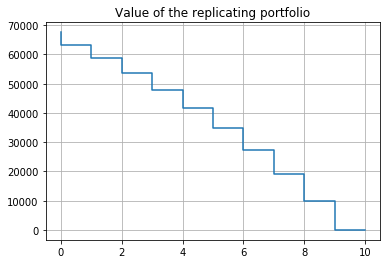

In [2]:
# problem data
N = 10
r = 0.10
P = 10000

# create model
m = ConcreteModel()

# decision variable
Stages = [k for k in range(0,N+1)]
m.y = Var(Stages,domain=NonNegativeReals)

# self-financing constraints
m.cons = ConstraintList()
for k in range(1,N+1):
    m.cons.add((m.y[k-1]-P)*(1+r) >= m.y[k])
    
# find minimum cost portfolio that satisfies the self-financing constraint
m.OBJ = Objective(expr = m.y[0], sense=minimize)

# solve
SolverFactory('glpk').solve(m)

plt.step(Stages,[m.y[k]() for k in Stages],where='pre')
plt.title('Value of the replicating portfolio')
plt.grid()

## Example 2. Simplico gold mine

The Simplico Gold Mine is a well-known example due to Luenberger. Up to 10,000 ounces per year can be extracted from the gold mine at a processing cost of \$200/oz. We assume the price of gold is currently \$400/oz. and can modeled on a binomial lattice with u = 1.2, d=0.9, a probability 0.75 that the price increases. The cost of borrowing money is equal to 10% per year. Gold extracted during the year is sold at the end of the year for the price that prevailed at the start of the year. 

What is the value of a 10 year lease on the gold mine?

### Solution

As a first step towards a solution, we compute a binomial lattice for the price of gold using the giving information.

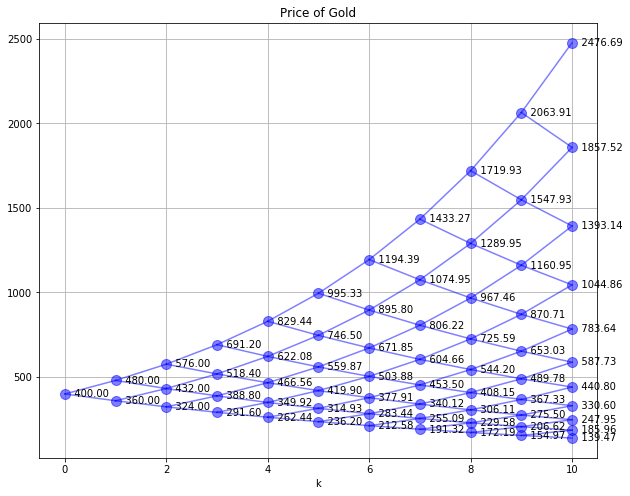

In [3]:
# utility function to plot binomial tree
def SPdisplay(Sf,D,title=''):
    """
    SPdisplay(Sf,D,title)
        Sf: binomial tree of future prices
        D: binomial tree of data to display for each node
        title: plot title
    """
    plt.figure(figsize=(10,8))
    nPeriods = max([k for k,s in Sf.keys()]) + 1
    for k,s in Sf.keys():
        plt.plot(k,Sf[k,s],'.',ms=20,color='b',alpha=0.5)
        if (k > 0) & (s < k):
            plt.plot([k-1,k],[Sf[k-1,s],Sf[k,s]],'b',alpha=.5)
            plt.plot([k-1,k],[Sf[k-1,s],Sf[k,s+1]],'b',alpha=.5)
    for k,s in D.keys():
        plt.text(k,Sf[k,s],'   {0:.2f}'.format(D[k,s]),ha='left',va='center')
    plt.xlabel('k')
    plt.grid()
    plt.title(title)

N = 10
u = 1.2
d = 0.9
p = 0.75
r = 0.10

# initialize Sf
Sf = {}
Sf[0,0] = 400
for k in range(1,N+1):
    for s in range(0,k+1):
        Sf[k,s] = u**(k-s)*d**s*Sf[0,0]
        
SPdisplay(Sf,Sf,'Price of Gold')

The second step is to solve an optimization model for the lease value. Let $W_{k,s}$ denotethe value of the option at end of stage $k$ and in state $s$. The terminal value of the lease is zero, i.e., 

$$W_{N,s} = 0\qquad\forall s$$

The self-financing constraints are

\begin{align*}
x_{k-1,s}S^f_{k,s} + y_{k-1,s}(1+r) & \geq W_{k,s}  + Q_{k,s}\\
x_{k-1,s}S^f_{k,s+1} + y_{k-1,s}-P_{k,s}(1+r) & \geq W_{k,s+1} + Q_{k,s+1}
\end{align*}

where $Q_{k,s}$ and $Q_{k,s+1}$ are the possible earnings from processing gold in stage $k$ and state $s$. In this problem the lease owner has the option, but not the requirement, to process gold and may therefore elect not to operate the gold mine if the return is negative.  Thus

$$Q_{k,s} = Q_{k,s+1} = \max(0, 10000(S^f_{k-1,s}-200))$$

where is $S^f_{k-1,s}$ is the price of gold at the start of the stage and 200.

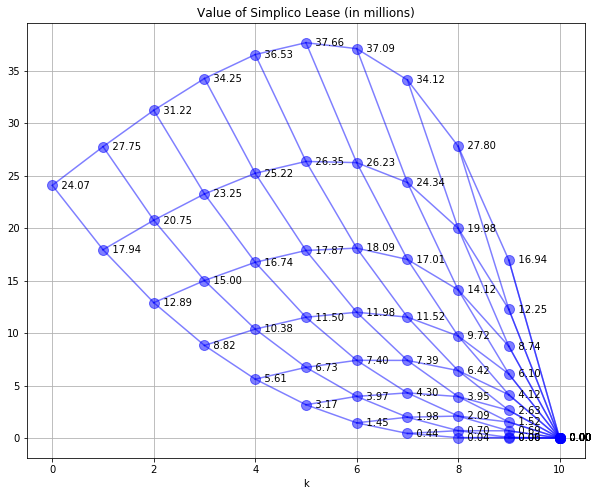

In [4]:
# set of periods and states for each period
Stages = range(0,N+1)
States = range(0,N+1)

# create model
m = ConcreteModel()

# model variables
m.W = Var(Stages,States,domain=Reals)
m.y = Var(Stages,States,domain=Reals)
m.x = Var(Stages,States,domain=Reals)

# objective
m.OBJ = Objective(expr = m.W[0,0], sense=minimize)

# constraint list
m.cons = ConstraintList()

# definition of option value
for k in Stages:
    for s in range(0,k+1):
        m.cons.add(m.W[k,s] == m.x[k,s]*Sf[k,s] + m.y[k,s])

# value of the lease at termination is zero
for s in range(0,N+1):
    m.cons.add(m.W[N,s] >= 0)

# self-financing constraints
for k in range(1,N+1):
    for s in range(0,k):
        m.cons.add(m.x[k-1,s]*Sf[k,s] + m.y[k-1,s]*(1+r) 
                   >= m.W[k,s] + 10000*max(0,(Sf[k-1,s]-200)))
        m.cons.add(m.x[k-1,s]*Sf[k,s+1] + m.y[k-1,s]*(1+r) 
                   >= m.W[k,s+1] + 10000*max(0,(Sf[k-1,s]-200)))

# solve
SolverFactory('glpk').solve(m)

# post-process solution
W = {}
for k in range(0,N+1):
    for s in range(0,k+1):
        W[k,s] = m.W[k,s]()/1e6
        
# display
SPdisplay(W,W,'Value of Simplico Lease (in millions)')

The value of the lease is \$24.07 million.

## Example 3. Simplico gold mine capital investment

Next we consider an option to make a capital improvement in the gold mine following a [Real Options analysis by Martin Haugh](http://www.columbia.edu/~mh2078/FoundationsFE/RealOptions.pdf). The option increases the gold output by 25% to 12,500 oz./year. The required investment is a \$4 million capital expense and an on-going increase in operating costs from \$200/oz. to \$240/oz. There would be no residual value resulting from the investment. The task is to determine if this option has value and, if so, how the option should be implemented.

We begin the analysis by computing the value of Simplico Gold Mine with this enhancement in place.

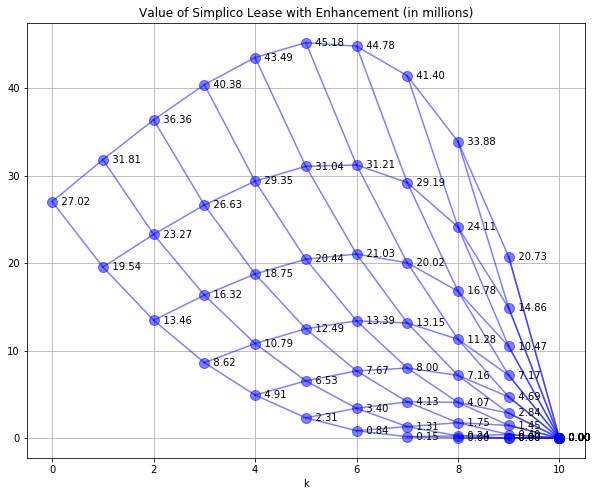

In [5]:
# set of periods and states for each period
Stages = range(0,N+1)
States = range(0,N+1)

# create model
m = ConcreteModel()

# model variables
m.Woption = Var(Stages,States,domain=Reals)
m.yoption = Var(Stages,States,domain=Reals)
m.xoption = Var(Stages,States,domain=Reals)

# objective
m.OBJ = Objective(expr = m.Woption[0,0], sense=minimize)

# constraint list
m.cons = ConstraintList()

# definition of option value
for k in Stages:
    for s in range(0,k+1):
        m.cons.add(m.Woption[k,s] == m.xoption[k,s]*Sf[k,s] + m.yoption[k,s])

# value of the lease at termination is zero
for s in range(0,N+1):
    m.cons.add(m.Woption[N,s] >= 0)

# self-financing constraints
for k in range(1,N+1):
    for s in range(0,k):
        m.cons.add(m.xoption[k-1,s]*Sf[k,s] + m.yoption[k-1,s]*(1+r) 
                   >= m.Woption[k,s] + 12500*max(0,(Sf[k-1,s]-240)))
        m.cons.add(m.xoption[k-1,s]*Sf[k,s+1] + m.yoption[k-1,s]*(1+r) 
                   >= m.Woption[k,s+1] + 12500*max(0,(Sf[k-1,s]-240)))

# solve
SolverFactory('glpk').solve(m)

# post-process solution
Woption = {}
for k in range(0,N+1):
    for s in range(0,k+1):
        Woption[k,s] = m.Woption[k,s]()/1e6
        
# display
SPdisplay(Woption,Woption,'Value of Simplico Lease with Enhancement (in millions)')

Immediate implementation of the capital expansion would raise the initial of the lease from \$24.07 to \$27.02 million accounting for the increase in capacity and operating cost. The increase of \$2.95 million is not enough to justify an initial capital investment of \$4 million.

We can see this difference more clearly by plotting the difference in lease values between the enhanced gold mine and the gold mine without enhancement.

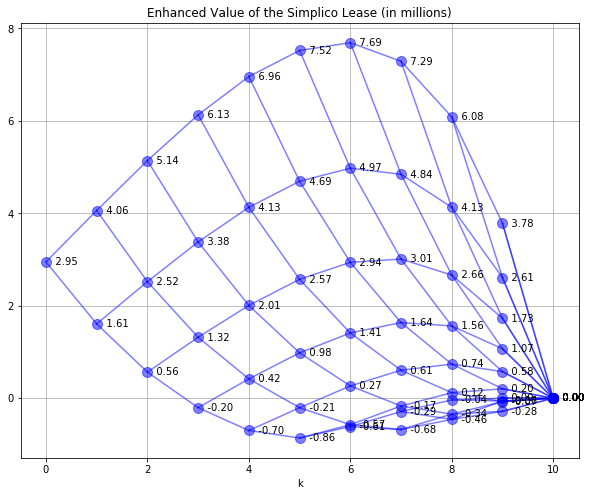

In [6]:
# post-process solution
E = {}
for k in range(0,N+1):
    for s in range(0,k+1):
        E[k,s] = Woption[k,s] - W[k,s]
        
# display
SPdisplay(E,E,'Enhanced Value of the Simplico Lease (in millions)')

Nodes above the \$4 million threshold correspond to scenarios where the operator would increase value by electing to implement the mine enhancements. Those scenarios are characterized by high gold prices occuring relatively early in the course of the lease.

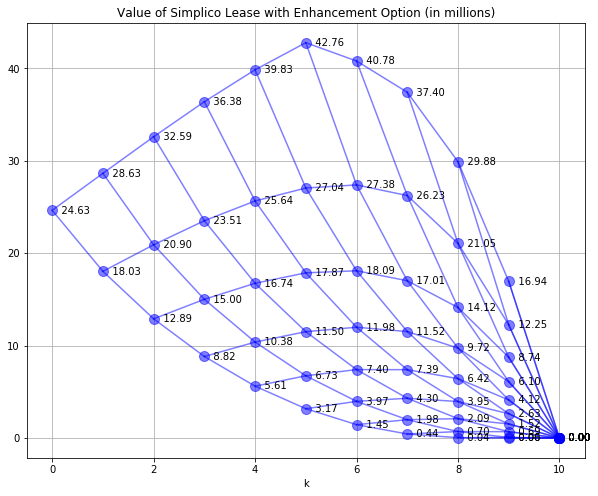

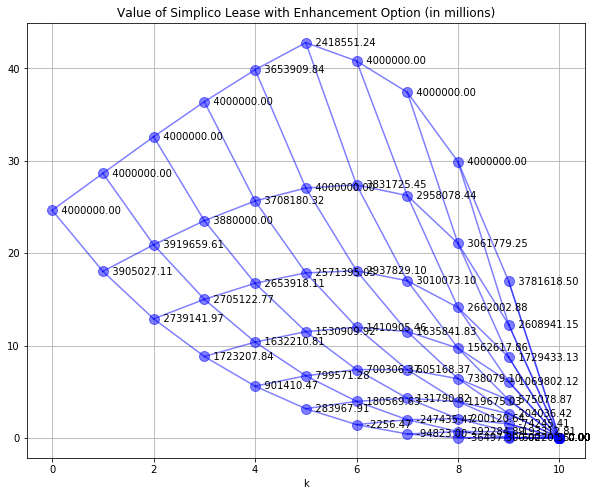

In [7]:
# set of periods and states for each period
Stages = range(0,N+1)
States = range(0,N+1)

# create model
m = ConcreteModel()

# model variables
m.W = Var(Stages,States,domain=Reals)
m.y = Var(Stages,States,domain=Reals)
m.x = Var(Stages,States,domain=Reals)
m.Woption = Var(Stages,States,domain=Reals)
m.yoption = Var(Stages,States,domain=Reals)
m.xoption = Var(Stages,States,domain=Reals)

# objective
m.OBJ = Objective(expr = m.W[0,0], sense=minimize)

# constraint list
m.cons = ConstraintList()

# definition of option value
for k in Stages:
    for s in range(0,k+1):
        m.cons.add(m.W[k,s] == m.x[k,s]*Sf[k,s] + m.y[k,s])
        m.cons.add(m.Woption[k,s] == m.xoption[k,s]*Sf[k,s] + m.yoption[k,s])
        m.cons.add(m.W[k,s] >= m.Woption[k,s] - 4000000)


# value of the lease at termination is zero
for s in range(0,N+1):
    m.cons.add(m.Woption[N,s] >= 0)
    m.cons.add(m.W[N,s] >= 0)

# self-financing constraints
for k in range(1,N+1):
    for s in range(0,k):
        
        m.cons.add(m.x[k-1,s]*Sf[k,s] + m.y[k-1,s]*(1+r) 
                   >= m.W[k,s] + 10000*max(0,(Sf[k-1,s]-200)))
        m.cons.add(m.x[k-1,s]*Sf[k,s+1] + m.y[k-1,s]*(1+r) 
                   >= m.W[k,s+1] + 10000*max(0,(Sf[k-1,s]-200)))

        m.cons.add(m.xoption[k-1,s]*Sf[k,s] + m.yoption[k-1,s]*(1+r) 
                   >= m.Woption[k,s] + 12500*max(0,(Sf[k-1,s]-240)))
        m.cons.add(m.xoption[k-1,s]*Sf[k,s+1] + m.yoption[k-1,s]*(1+r) 
                   >= m.Woption[k,s+1] + 12500*max(0,(Sf[k-1,s]-240)))

# solve
SolverFactory('glpk').solve(m)

# post-process solution
W = {}
E = {}
for k in range(0,N+1):
    for s in range(0,k+1):
        W[k,s] = m.W[k,s]()/1e6
        E[k,s] = m.Woption[k,s]() - m.W[k,s]()
        
# display
SPdisplay(W,W,'Value of Simplico Lease with Enhancement Option (in millions)')
SPdisplay(W,E,'Value of Simplico Lease with Enhancement Option (in millions)')

In this case the capital expense has been incorporated into the leave value calculations. Because the value of the lease has increased from the base case of \$24.07 to \$24.63 million, the availability of the option adds value to the lease.

## Example 4. Tree farm harvesting

### Price model

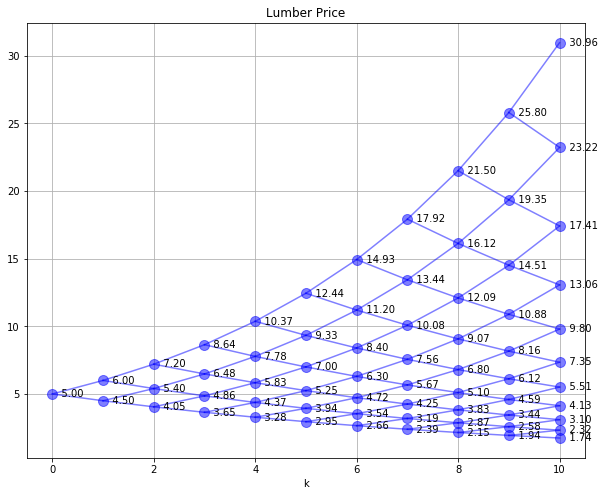

In [8]:
# model parameters
N = 10
u = 1.2
d = 0.9
r = 0.10

# initialize Sf
Sf = {}
Sf[0,0] = 5
for k in range(1,N+1):
    for s in range(0,k+1):
        Sf[k,s] = u**(k-s)*d**s*Sf[0,0]

# utility function to plot binomial tree
def SPdisplay(Sf,D,title=''):
    """
    SPdisplay(Sf,D,title)
        Sf: binomial tree of future prices
        D: binomial tree of data to display for each node
        title: plot title
    """
    plt.figure(figsize=(10,8))
    nPeriods = max([k for k,s in Sf.keys()]) + 1
    for k,s in Sf.keys():
        plt.plot(k,Sf[k,s],'.',ms=20,color='b',alpha=0.5)
        if (k > 0) & (s < k):
            plt.plot([k-1,k],[Sf[k-1,s],Sf[k,s]],'b',alpha=.5)
            plt.plot([k-1,k],[Sf[k-1,s],Sf[k,s+1]],'b',alpha=.5)
    for k,s in D.keys():
        plt.text(k,Sf[k,s],'   {0:.2f}'.format(D[k,s]),ha='left',va='center')
    plt.xlabel('k')
    plt.grid()
    plt.title(title)
    
SPdisplay(Sf,Sf,'Lumber Price')

### Growth model

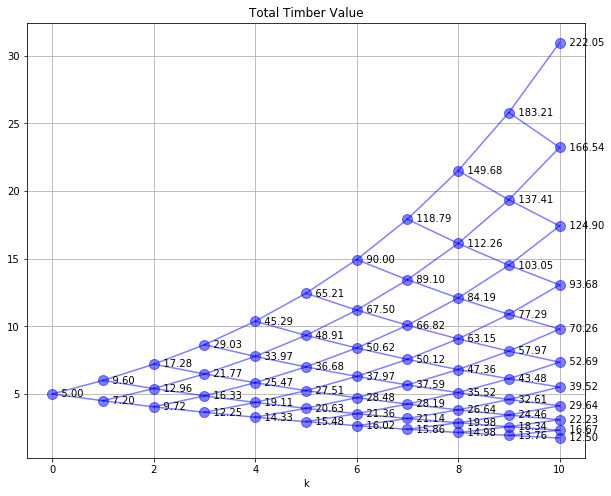

In [9]:
Q = {}
Q[0] = 1
Q[1] = Q[0]*1.6
Q[2] = Q[1]*1.5
Q[3] = Q[2]*1.4
Q[4] = Q[3]*1.3
Q[5] = Q[4]*1.2
Q[6] = Q[5]*1.15
Q[7] = Q[6]*1.1
Q[8] = Q[7]*1.05
Q[9] = Q[8]*1.02
Q[10] = Q[9]*1.01

QSf = {}
Periods = Q.keys()
for k in Periods:
    for s in range(0,k+1):
        QSf[k,s] = Q[k]*Sf[k,s]
        
SPdisplay(Sf,QSf,'Total Timber Value')

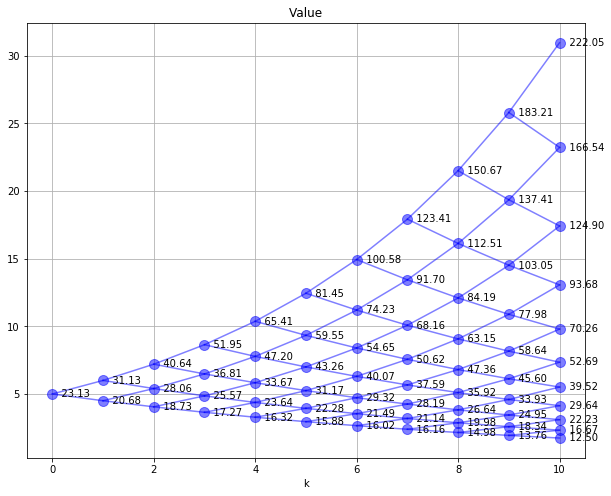

In [10]:
# set of periods and states for each period
Stages = range(0,N+1)
States = range(0,N+1)

# create model
m = ConcreteModel()

# model variables
m.W = Var(Stages,States,domain=Reals)
m.x = Var(Stages,States,domain=Reals)
m.y = Var(Stages,States,domain=Reals)

# objective
m.OBJ = Objective(expr = m.W[0,0], sense=minimize)

# constraint list
m.cons = ConstraintList()

# definition of W[k,s]
for k in Stages:
    for s in range(0,k+1):
        m.cons.add(m.W[k,s] == m.x[k,s]*Sf[k,s] + m.y[k,s])

# self-financing constraints
for k in range(0,N):
    for s in range(0,k+1):
        m.cons.add(m.x[k,s]*Sf[k+1,s] + (m.y[k,s] + 2)*(1+r) >= m.W[k+1,s])
        m.cons.add(m.x[k,s]*Sf[k+1,s+1] + (m.y[k,s] + 2)*(1+r) >= m.W[k+1,s+1])
        
# harvest option
for k in Stages:
    for s in range(0,k+1):
        m.cons.add(m.W[k,s] >= Q[k]*Sf[k,s])

# solve
SolverFactory('glpk').solve(m) 

# post-process solution
W = {}
for k in range(0,N+1):
    for s in range(0,k+1):
        W[k,s] = m.W[k,s]()
        
# display
SPdisplay(Sf,W,'Value')

<!--NAVIGATION-->
< [MAD Portfolio Optimization](http://nbviewer.jupyter.org/github/jckantor/ND-Pyomo-Cookbook/blob/master/notebooks/08.04-MAD-Portfolio-Optimization.ipynb) | [Contents](toc.ipynb) | [Index](index.ipynb) | [Style Guide](http://nbviewer.jupyter.org/github/jckantor/ND-Pyomo-Cookbook/blob/master/notebooks/A.00-Style-Guide.ipynb) ><p><a href="https://colab.research.google.com/github/jckantor/ND-Pyomo-Cookbook/blob/master/notebooks/08.05-Real-Options.ipynb"><img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open in Google Colaboratory"></a>